In [1]:
from sklearn.cluster import AgglomerativeClustering, KMeans
import numpy as np
import seaborn as sns
import pandas as pd
import random

from diurnal_misinformation.config import ItalyConfig
from diurnal_misinformation.enums import Columns, Clusters
from diurnal_misinformation.cluster_utils import ClusterRoutine, cluster_center_df
from diurnal_misinformation.path_utils import get_cluster_col_path

In [2]:
random_seed = 12
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
config = ItalyConfig()
methods = {
    'kmeans': KMeans(random_state=random_seed),
    'hierarchical': AgglomerativeClustering(linkage='ward', metric='euclidean'),
}
processor = ClusterRoutine(config, methods=methods, cutoff_post_nr=240)

# Pseudo-Chronotypes

We assume circadian variation on two levels: Variation in ratios of machinated content and variation in access to Twitter/capacity to tweet. We need to disentangle both effects.

## Aggregation
Ideally, we would model the time series continuously per each user over the time period that we have available, and then to separate seasonality/cyclical patterns, trend, and noise. This would allow us to isolate seasonality. However (1) that's resource-intense, (2) our data is so sparse it may not make much sense for all but the most active users and (3) few Twitter users are persistant, in that the inter-individual similarity in between subsequent days is small.

## Smoothing

We're trying to model one "standard" day for each user. Most Twitter users, however, don't necessarily post enough to fill all 15-minute bins with some value even if they are on Twitter, so we have to interpolate (this is not a problem for users who post a lot, as we've seen above).

We only have 24\*4=96 datapoints, meaning that we should not assume a distribution (we can't rely on the rule of large numbers either). So parametric fitting can lead to fitting a smooth curve that misrepresents the data. This leaves non-parametric smoothing methods like LOWESS or moving averages.

LOWESS/LOESS require fairly large, densely sampled data sets since they fit a model over local data structures, plus is sensitive to outliers. We just have one datapoint every 15 minutes. So moving average seems the better choice. Closed domain is sufficient for our use case, so we don't need EWA for responsiveness. Weighted moving average seemed a reasonable compromise between smoothing and data point consideration.

I chose the window size as 90 minutes because a) it gave good results and b) is suits the human ultradian rhythm.

Note that this is just for clustering: We'll apply Fourier smoothing afterwards on the aggregated curves.

In [4]:
processor.smooth_user_activity(padding=3, std=3)

# Clustering

Let's compare hierarchical and kmeans clustering. We want at least 3 clusters for a sensible analysis. We can compare element-wise per index to find the more promising candidate.

Generally, we want to measure when people are awake, so it's important to collect all the Tweets.

In [5]:
cluster_result_all = processor.routine_by(processor.smoothed_user_activity, 'all')

Clustered into 3 clusters using kmeans


Text(0.5, 0, 'time')

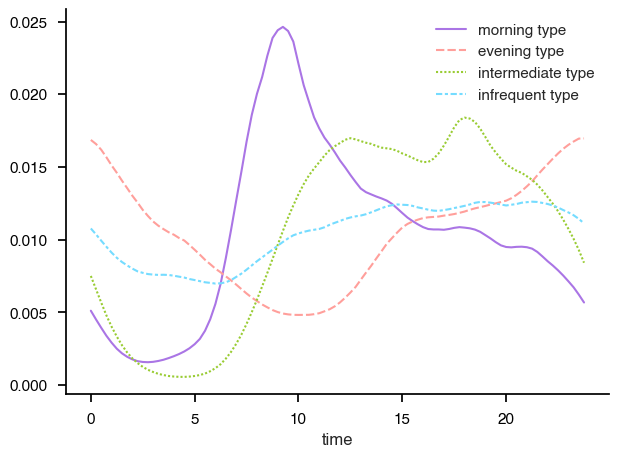

In [6]:
import warnings
import scripts.__init__
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

g = sns.lineplot(
    pd.DataFrame(cluster_result_all.cluster_centers, columns=processor.smoothed_user_activity.columns).rename(index=cluster_result_all.num_to_name).T, 
    palette=Clusters.palette())
g.set_xlabel('time')


## Cluster stats

In [7]:
stats_dist_df_style = processor.get_cluster_stats_distance_table_style(cluster_result_all, save=True)
stats_dist_df_style


,number of users,number of posts,posts per user,infrequent type,morning type,intermediate type,evening type
infrequent type,"860,228","7,858,209",9.14,0.408,-,-,-
morning type,"3,155","2,815,887",892.52,0.058,0.131,-,-
intermediate type,"5,461","5,199,655",952.14,0.044,0.061,0.111,-
evening type,"2,654","2,338,475",881.11,0.035,0.090,0.073,0.158


# Unverified
We should validate that the clusters found when considering all users are representative of Tweets by unverified users only.

In [8]:
unverified_users = processor.data.xs(False, level=Columns.VERIFIED.value).index.unique(level=Columns.USERHASH.value)
cluster_result_unverified = processor.routine_by(processor.smoothed_user_activity.loc[unverified_users], 'unverified')

Clustered into 3 clusters using kmeans


<Axes: xlabel='min_bins15', ylabel='0'>

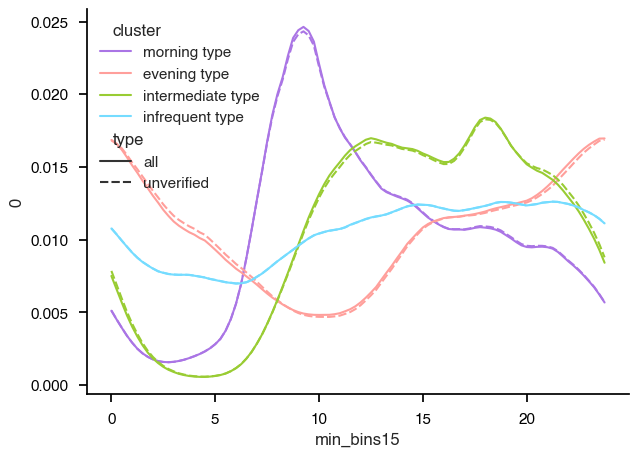

In [9]:
sns.lineplot(
    data=pd.concat([
        cluster_center_df(cluster_result_all),
        cluster_center_df(cluster_result_unverified),
    ], keys=['all', 'unverified']).stack().reset_index().rename(columns={'level_0': 'type'}), 
    x=Columns.MIN_BINS15.value, y=0, palette=Clusters.palette(), hue='cluster', style='type')

## Cluster Stats

In [10]:
processor.get_cluster_stats_distance_table_style(cluster_result_unverified, save=True)

,number of users,number of posts,posts per user,infrequent type,morning type,intermediate type,evening type
infrequent type,"858,188","7,801,792",9.09,0.408,-,-,-
morning type,"3,157","2,802,925",887.84,0.058,0.132,-,-
intermediate type,"5,397","5,105,142",945.92,0.043,0.061,0.112,-
evening type,"2,516","2,182,114",867.29,0.036,0.090,0.073,0.157


# Verified

In [11]:
cluster_result_verified = processor.routine_by(processor.smoothed_user_activity.loc[processor.smoothed_user_activity.index.difference(unverified_users)], 'verified')

Clustered into 3 clusters using kmeans


## Stats

In [12]:
processor.get_cluster_stats_distance_table_style(cluster_result_verified, save=False)

,number of users,number of posts,posts per user,infrequent type,morning type,intermediate type,evening type
infrequent type,"2,040","56,417",27.66,0.422,-,-,-
morning type,13,"16,882","1,298.62",0.147,0.059,-,-
intermediate type,186,"246,511","1,325.33",0.017,0.143,0.057,-
evening type,1,443,443.00,0.318,0.368,0.322,0.000


There are only 200 verified users with >= 240 posts in our data set, and only one evening type

# Comparison

Curve features of all, unverified and verified:

In [13]:
results = [cluster_result_all, cluster_result_unverified, cluster_result_verified]
merged_centers=pd.concat(list(map(lambda r: cluster_center_df(r), results)), keys=list(map(lambda r: r.label, results)), names=['type'], axis=0)
cluster_cols = pd.concat(list(map(lambda r: r.clustercol.map(r.num_to_name), results)), keys=list(map(lambda r: r.label, results)), axis=1)

In [14]:
cluster_cols.loc[(cluster_cols['all'] != cluster_cols['verified']) & ~cluster_cols['verified'].isna(), ['all', 'verified']].value_counts().unstack(fill_value=0)

verified,evening type,intermediate type
all,,
evening type,0,27
intermediate type,1,0
morning type,0,50


In [15]:
cluster_cols.loc[(cluster_cols['all'] != cluster_cols['unverified']) & ~cluster_cols['unverified'].isna(), ['all', 'unverified']].value_counts().unstack(fill_value=0)

unverified,evening type,intermediate type,morning type
all,,,
evening type,0,107,5
intermediate type,0,0,65
morning type,1,4,0


107 users were assigned to the evening type column when clustering all users, and are intermediate when only considering unverified users

In [16]:
merged_centers.apply(lambda x: pd.Series((x.idxmax(), x.idxmin()), index=['max', 'min']), axis=1).unstack(level=0).loc[Clusters.order()]

max                        min                    
type                 all unverified verified    all unverified verified
cluster                                                                
infrequent type    21.25      21.25    12.25   6.00       6.00     5.75
morning type        9.25       9.25     9.25   2.75       2.75     2.75
intermediate type  18.00      18.00    11.75   4.50       4.50     5.50
evening type       23.75      23.75    14.25  10.00      10.50     0.00

<Axes: xlabel='min_bins15', ylabel='0'>

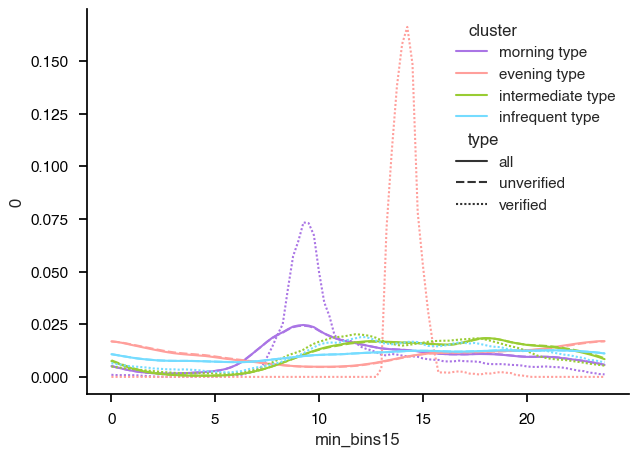

In [17]:
sns.lineplot(
    data=merged_centers.stack().reset_index().rename(columns={'level_1': 'cluster'}), 
    x=Columns.MIN_BINS15.value, y=0, palette=Clusters.palette(), hue='cluster', style='type')

# Storing results

In [18]:
cluster_cols.to_parquet(get_cluster_col_path(config), compression='gzip')